In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Leaf Trees
Running BUG for Trees where only the leafs have non-trivial physical legs

In [75]:
from copy import deepcopy

from numpy import asarray, eye, pi, kron, ndarray, append, abs as npabs
from matplotlib.pyplot import subplots, show

from pytreenet.core import Node
from pytreenet.ttns import TreeTensorNetworkState
from pytreenet.time_evolution.bug import BUG
from pytreenet.operators import TensorProduct, Hamiltonian
from pytreenet.operators.common_operators import ket_i, pauli_matrices, superposition
from pytreenet.ttno import TreeTensorNetworkOperator
from pytreenet.time_evolution.ttn_time_evolution import TTNTimeEvolutionConfig
from pytreenet.util.tensor_splitting import SVDParameters
from pytreenet.time_evolution.exact_time_evolution import ExactTimeEvolution

## Four-Qubit Binary Tree

Four qubits are is the shortest chain for which we can have a bond dimension larger then than the qubit dimension $2$.
One state requiring this is
$$
\ket{\psi} = \frac{1}{2} ( \ket{0000} + \ket{1110} + \ket{0101}+ \ket{1011})
$$
We can obtain this state from the initial state $\ket{0000}$ by applying the following circuit
$$
 \text{C}_1\text{NOT}_2 \cdot \text{C}_2\text{NOT}_1 \cdot (\text{C}_0\text{NOT}_1 \otimes \text{C}_3\text{NOT}_2) \cdot (H_0 \otimes H_3),
$$
where $H$ ist the Hadamard gate and $\text{C}_i\text{NOT}_j$ is the controlled Pauli-$X$ operation, with the controll qubit $i$.
We can obatain it from a TTN-time evolution, by running multiple evolutions each, with a gate evolution and the final state of the evolution before as the initial state.

### Preparation

In [76]:
time_step_size = 0.01

In [77]:
# State
one = asarray([1], dtype=complex)
ket_0 = ket_i(0,2)
superpos = superposition()

num_qubits = 4
binary_tree = TreeTensorNetworkState()
root_id = "Root"
mid_ids = ["MidLeft", "MidRight"]
qubit_ids = [f"Qubit{i}" for i in range(num_qubits)]

node_r = Node(identifier=root_id)
tensor = deepcopy(one.reshape(1,1,1))
binary_tree.add_root(node_r, tensor)
left_node = Node(identifier=mid_ids[0])
tensor = deepcopy(one.reshape(1,1,1,1))
binary_tree.add_child_to_parent(left_node, tensor, 0, root_id, 0)
right_node = Node(identifier=mid_ids[1])
tensor = deepcopy(one.reshape(1,1,1,1))
binary_tree.add_child_to_parent(right_node, tensor, 0, root_id, 1)

# qubits
q_node = Node(identifier=qubit_ids[0])
tensor = deepcopy(superpos.reshape(1,2))
binary_tree.add_child_to_parent(q_node, tensor, 0, mid_ids[0], 1)
q_node = Node(identifier=qubit_ids[1])
tensor = deepcopy(ket_0.reshape(1,2))
binary_tree.add_child_to_parent(q_node, tensor, 0, mid_ids[0], 2)
q_node = Node(identifier=qubit_ids[2])
tensor = deepcopy(ket_0.reshape(1,2))
binary_tree.add_child_to_parent(q_node, tensor, 0, mid_ids[1], 1)
q_node = Node(identifier=qubit_ids[3])
tensor = deepcopy(superpos.reshape(1,2))
binary_tree.add_child_to_parent(q_node, tensor, 0, mid_ids[1], 2)

In [78]:
def gen_cnot_hamiltonian(control_id: str,
                         target_id: str
                         ) -> Hamiltonian:
    """
    Generate a CNOT Hamiltonian for a given control and target qubit.

    Args:
        control_id: Identifier of the control qubit.
        target_id: Identifier of the target qubit.

    Returns:
        Hamiltonian: Hamiltonian for the CNOT gate.
    """
    dim = 2
    identity = eye(dim)
    term = TensorProduct({control_id: "q0_op", target_id: "q1_op"})
    q0_op = identity - pauli_matrices()[2]
    q1_op = identity - pauli_matrices()[0]
    conv_dict = {"I1": eye(1), "I2": identity, "q0_op": q0_op, "q1_op": q1_op}
    hamiltonian = Hamiltonian(term, conversion_dictionary=conv_dict)
    return hamiltonian

In [79]:
# Hamiltonians
fq_ham_1 = gen_cnot_hamiltonian(qubit_ids[0], qubit_ids[1])
fq_ham_1.add_hamiltonian(gen_cnot_hamiltonian(qubit_ids[3], qubit_ids[2]))
fq_ttno_1 = TreeTensorNetworkOperator.from_hamiltonian(fq_ham_1, binary_tree)
fq_ham_2 = gen_cnot_hamiltonian(qubit_ids[2], qubit_ids[1])
fq_ttno_2 = TreeTensorNetworkOperator.from_hamiltonian(fq_ham_2, binary_tree)
fq_ham_3 = gen_cnot_hamiltonian(qubit_ids[1], qubit_ids[2])
fq_ttno_3 = TreeTensorNetworkOperator.from_hamiltonian(fq_ham_3, binary_tree)

In [80]:
# Z-Operators
fq_ops = {qubit_ids[i]: TensorProduct({qubit_ids[i]: pauli_matrices()[2]}) for i in range(num_qubits)}

### Simulation

In [81]:
final_time = pi / 4 # This is how long it takes a CNOT to run
svd = SVDParameters(rel_tol=0.0,total_tol=0.0)
config = TTNTimeEvolutionConfig(record_bond_dim=True)
fq_bug1 = BUG(binary_tree, fq_ttno_1, time_step_size, final_time, fq_ops, config=config, svd_params=svd)
fq_bug1.run()
fq_bug2 = BUG(fq_bug1.state, fq_ttno_2, time_step_size, final_time, fq_ops, config=config, svd_params=svd)
fq_bug2.run()
fq_bug3 = BUG(fq_bug2.state, fq_ttno_3, time_step_size, final_time, fq_ops, config=config, svd_params=svd)
fq_bug3.run()

100%|██████████| 80/80 [00:00<00:00, 87.07it/s]


### Exact Simulation

In [82]:
# State
fq_ref_state = kron(kron(superpos, ket_0), kron(ket_0, superpos))

In [83]:
def gen_cnot_ham_matrix(control: bool) -> ndarray:
    """
    Generate the matrix representation of a CNOT gate Hamiltonian.

    Args:
        control: Whether the left qubit is te control qubit (True) or the right qubit (False).

    Returns:
        ndarray: Matrix representation of the CNOT gate Hamiltonian.

    """
    dim = 2
    identity = eye(dim)
    sigma_x, _, sigma_z = pauli_matrices()
    if control:
        return kron(identity - sigma_z, identity - sigma_x)
    else:
        return kron(identity - sigma_x, identity - sigma_z)

In [84]:
# Hamiltonians
dim = 2
identity = eye(dim)
fq_ref_ham_1 = kron(gen_cnot_ham_matrix(True), gen_cnot_ham_matrix(False))
fq_ref_ham_2 = kron(identity, kron(gen_cnot_ham_matrix(False), identity))
fq_ref_ham_3 = kron(identity, kron(gen_cnot_ham_matrix(True), identity))

In [85]:
# Operators
fq_ref_ops = {qubit_ids[i]: kron(eye(dim**i), kron(pauli_matrices()[2], eye(dim**(num_qubits-i-1)))) for i in range(num_qubits)}
print([op.shape for op in fq_ref_ops.values()])

[(16, 16), (16, 16), (16, 16), (16, 16)]


In [86]:
# Simulation
fq_exact1 = ExactTimeEvolution(fq_ref_state, fq_ref_ham_1, time_step_size, final_time, fq_ref_ops)
fq_exact1.run()
fq_exact2 = ExactTimeEvolution(fq_exact1.state, fq_ref_ham_2, time_step_size, final_time, fq_ref_ops)
fq_exact2.run()
fq_exact3 = ExactTimeEvolution(fq_exact2.state, fq_ref_ham_3, time_step_size, final_time, fq_ref_ops)
fq_exact3.run()

100%|██████████| 80/80 [00:00<00:00, 31043.05it/s]


### Results & Plots

In [87]:
times = append(fq_bug1.times(), append(fq_bug2.times(offset=pi/4), fq_bug3.times(offset=pi/2)))

In [88]:
def bug_results(qubit_id: str) -> ndarray:
    """
    Gets the results of the BUG simulations for a given qubit and concatenates them.
    """
    return append(fq_bug1.operator_result(qubit_id, realise=True), append(fq_bug2.operator_result(qubit_id, realise=True), fq_bug3.operator_result(qubit_id, realise=True)))

def exact_results(qubit_id: str) -> ndarray:
    """
    Gets the results of the exact simulations for a given qubit and concatenates them.
    """
    return append(fq_exact1.operator_result(qubit_id, realise=True), append(fq_exact2.operator_result(qubit_id, realise=True), fq_exact3.operator_result(qubit_id, realise=True)))

In [89]:
fq_results = [bug_results(qubit_id) for qubit_id in qubit_ids]
fq_exact_results = [exact_results(qubit_id) for qubit_id in qubit_ids]
fq_errors = [npabs(fq_results[i] - fq_exact_results[i]) for i in range(num_qubits)]

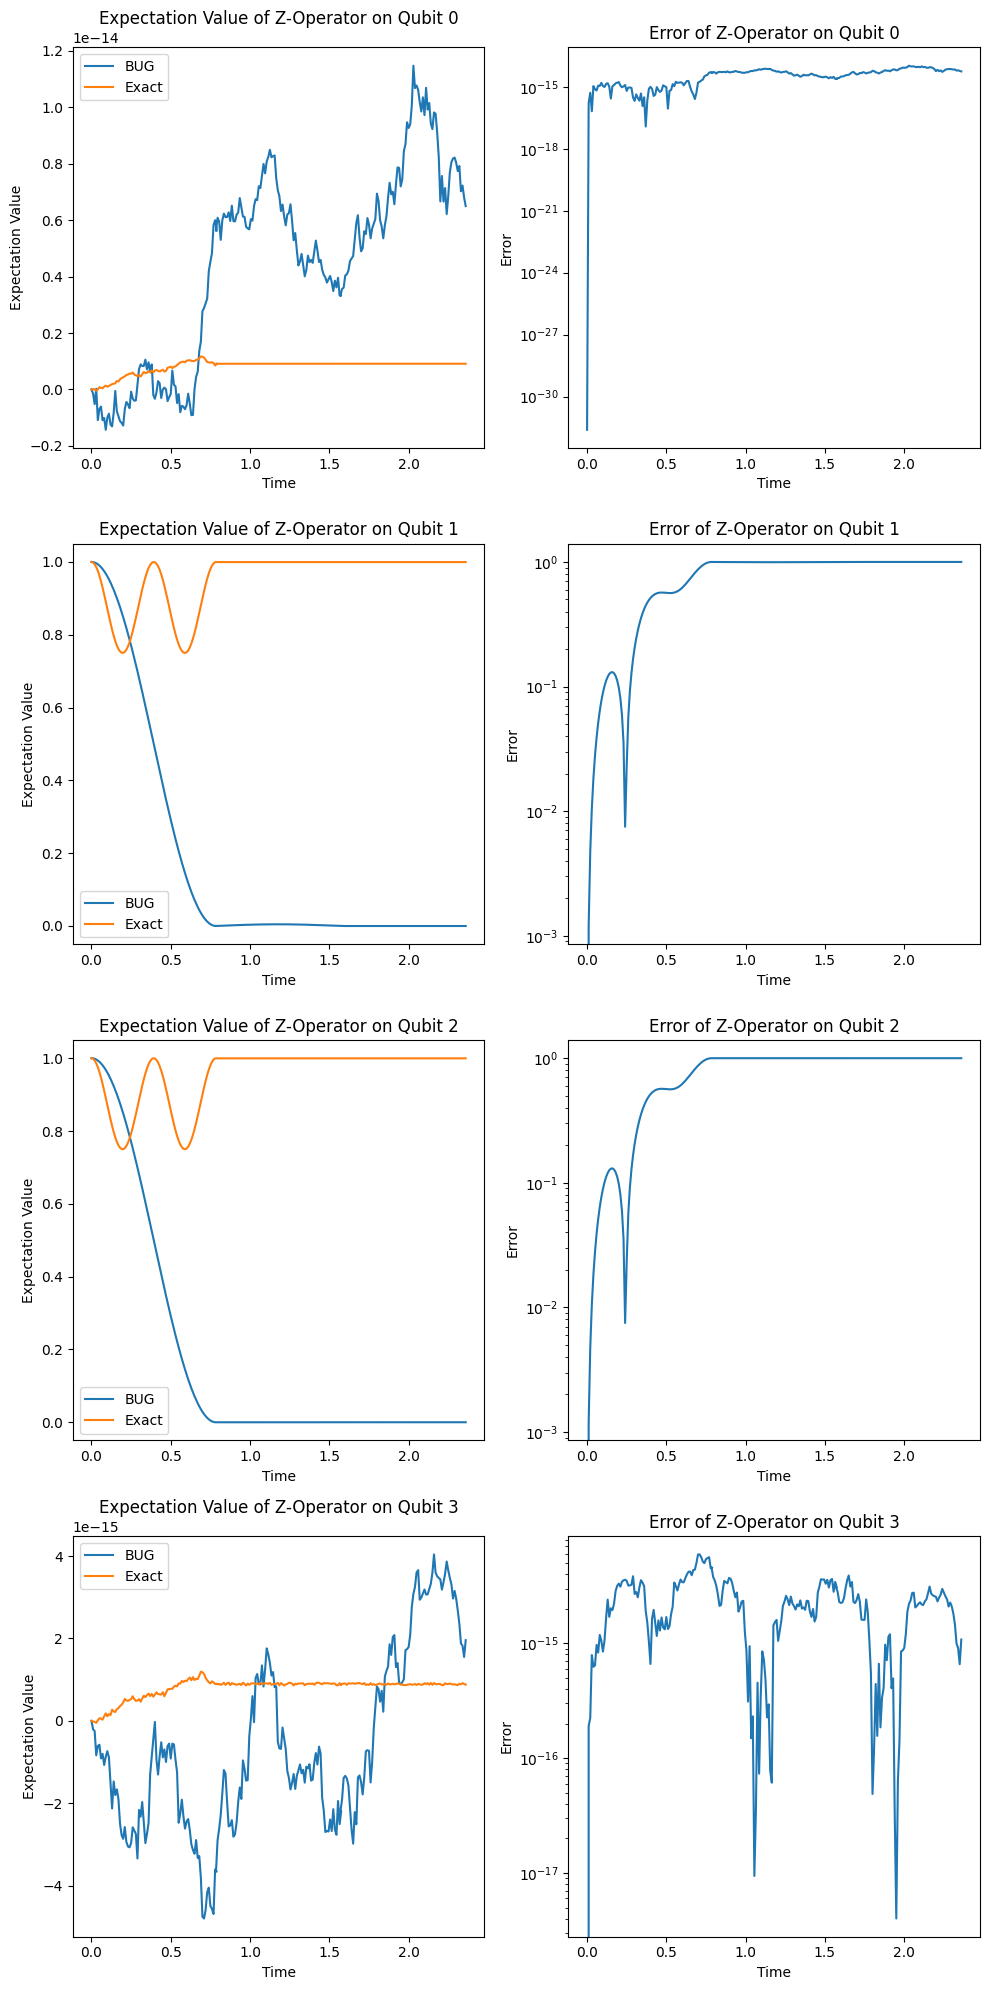

In [91]:
fig, axs = subplots(4, 2, figsize=(10, 20))

for i in range(num_qubits):
    axs[i,0].plot(times, fq_results[i], label="BUG")
    axs[i,0].plot(times, fq_exact_results[i], label="Exact")
    axs[i,0].set_xlabel("Time")
    axs[i,0].set_ylabel("Expectation Value")
    axs[i,0].set_title(f"Expectation Value of Z-Operator on Qubit {i}")
    axs[i,0].legend()

    axs[i,1].semilogy(times, fq_errors[i])
    axs[i,1].set_xlabel("Time")
    axs[i,1].set_ylabel("Error")
    axs[i,1].set_title(f"Error of Z-Operator on Qubit {i}")

fig.tight_layout()
show()